In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
def generate_X(m, d):
    return np.random.normal(0,1,(m,d))

def generate_theta(d):
    a = np.random.rand(d)
    return np.array(a > 0.5).astype(int)

def generate_noise(std, m):
    return np.random.normal(0,std,m)

def compute_y(X, theta, noise):
    return np.dot(X, theta) + noise

def acceptance_function(beta, cur_cost, prop_cost):
    if prop_cost < cur_cost:
        return 1
    else:
        return math.exp(-beta * (prop_cost - cur_cost))

def proposal_generator(cur_state):
    bit = np.random.randint(0,len(cur_state))
    prop = np.copy(cur_state)
    prop[bit] = 1-cur_state[bit]
    return prop, bit

# k : bit that is flipped
def fast_cost_func2(prev_u, prev_Xu, k, noise_std, y, X):
    prop_Xv = prev_Xu + X[:,k] if prev_u[k] == 0 else prev_Xu - X[:,k]
    s = np.linalg.norm(y - prop_Xv)**2
    return s/(2*noise_std*noise_std), prop_Xv

def mse(a,b):
    return 2*np.mean(np.square(a - b))

In [13]:
def MH(X, y, noise_std, cost_func, initial_state, beta, n_iter, proposal_generator, acceptance_func):
    
    cur_state = initial_state
    cur_Xu = np.dot(X, cur_state)
    cur_cost =  np.linalg.norm(y - cur_Xu)**2 / (2*noise_std*noise_std)

    for i in range(n_iter):
        proposal, k = proposal_generator(cur_state)
        prop_cost, prop_Xv = cost_func(cur_state, cur_Xu, k, noise_std, y, X)

        acceptance = acceptance_func(beta, cur_cost, prop_cost)

        if np.random.rand() < acceptance:
            # Accept move
            cur_state = proposal
            cur_Xu = prop_Xv
            cur_cost = prop_cost

    return cur_state


def simulated_annealing(X, y, noise_std, cost_func, initial_state, initial_beta, beta_increase_factor, n_iter, proposal_generator, acceptance_func):
    cur_state = initial_state
    cur_Xu = np.dot(X, cur_state)
    cur_cost =  np.linalg.norm(y - cur_Xu)**2 / (2*noise_std*noise_std)

    beta = initial_beta

    for i in range(n_iter):
        proposal, k = proposal_generator(cur_state)
        prop_cost, prop_Xv = cost_func(cur_state, cur_Xu, k, noise_std, y, X)

        acceptance = acceptance_func(beta, cur_cost, prop_cost)

        if np.random.rand() < acceptance:
            # Accept move
            cur_state = proposal
            cur_Xu = prop_Xv
            cur_cost = prop_cost

        beta *= beta_increase_factor

    return cur_state
        

In [11]:
# Run Metropolis Hasting algorithm for different values of m and beta
# Compute mean over n_repet repetitions

d = 2000
noise_std = 1.0
n_iter = 100*d
n_repet = 1

betas = [0.01, 0.1, 1.0, 10.0]
ms = [math.floor(d/a) for a in [d,4,2,1]]

mses = np.zeros((len(betas), len(ms), n_repet))

for (ib, beta) in enumerate(betas):
    for (im, m) in enumerate(ms):
        for ir in range(n_repet):
            X = generate_X(m,d)
            theta = generate_theta(d)
            noise = generate_noise(noise_std, m)
            y = compute_y(X, theta, noise)
            
            initial_state = generate_theta(d)
            final_state = MH(X, y, noise_std, fast_cost_func2, initial_state, beta, n_iter, proposal_generator, acceptance_function)
            mses[ib, im, ir] = mse(theta, final_state)

/var/folders/pf/thlth2p50fb8fnhjhs8t_ysm0000gn/T/ipykernel_27854/2799374647.py:7: RuntimeWarning: invalid value encountered in divide
  np.sum(np.square(score.T-mean_score), axis=0)/(n_repet-1)


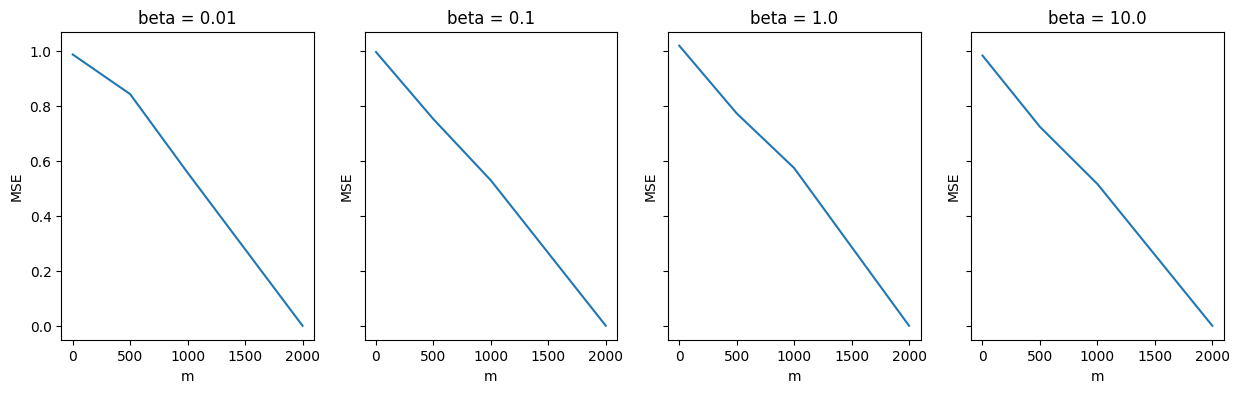

In [12]:
# Plot the results: mean and std
fig, axs = plt.subplots(1, len(betas), figsize=(15,4), sharey=True)
for ib in range(len(betas)):
    score = mses[ib, :, :]
    mean_score = np.mean(score, axis=1)
    sample_dev = np.sqrt(
        np.sum(np.square(score.T-mean_score), axis=0)/(n_repet-1)
        )

    axs[ib].plot(ms, mean_score)
    axs[ib].fill_between(ms, mean_score+sample_dev, mean_score-sample_dev, alpha=0.2)

    axs[ib].set_title("beta = "+str(betas[ib]))
    axs[ib].set_xlabel("m")
    axs[ib].set_ylabel("MSE")

plt.savefig("MH_test.png")

In [14]:
# Run Simulated Annealing for different values of m
# Compute mean over n_repet repetitions

d = 2000
noise_std = 1.0
n_iter = 100*d
n_repet = 10

initial_beta = 0.01
beta_max = 10.0
beta_increase_factor = (beta_max/initial_beta)**(1/n_iter)

ms_sa = [math.floor(d/a) for a in [d,4,2,1]]

mses_sa = np.zeros((len(ms), n_repet))


for (im, m) in enumerate(ms_sa):
    for ir in range(n_repet):
        X = generate_X(m,d)
        theta = generate_theta(d)
        noise = generate_noise(noise_std, m)
        y = compute_y(X, theta, noise)
        
        initial_state = generate_theta(d)
        final_state = simulated_annealing(X, y, noise_std, fast_cost_func2, initial_state, initial_beta, beta_increase_factor, n_iter, proposal_generator, acceptance_function)

        mses_sa[im, ir] = mse(theta, final_state)

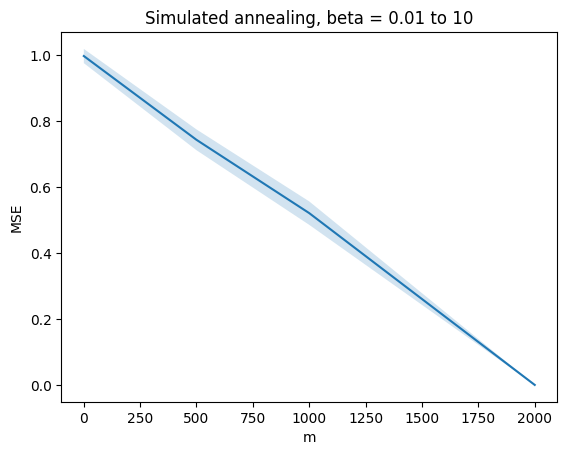

In [17]:
score = mses_sa
mean_score = np.mean(score, axis=1)
sample_dev = np.sqrt(
    np.sum(np.square(score.T-mean_score), axis=0)/(n_repet-1)
    )
#err_bar = 1.96 * sample_dev / math.sqrt(n_repet)

plt.plot(ms, mean_score)
plt.fill_between(ms, mean_score+sample_dev, mean_score-sample_dev, alpha=0.2)

plt.title("Simulated annealing, beta = 0.01 to 10")
plt.xlabel("m")
plt.ylabel("MSE")

plt.savefig("SA.png")

In [ ]:
#def slow_cost_func(state, noise_std, y, X):
#    cost = 1/(2*noise_std**2) * (np.linalg.norm(y - np.dot(X,state))**2)
#    return cost

# k : bit that is flipped
#def fast_cost_func(prev_u, prev_Xu, k, noise_std, y, X):
#    if prev_u[k] == 0:
#        prop_Xv = prev_Xu + X[:,k]
#        s = np.square(X[:,k]) - 2* np.multiply(X[:,k], (y - prev_Xu))
#        return sum(s)/(2*noise_std*noise_std), prop_Xv
#    else:
#        prop_Xv = prev_Xu - X[:,k]
#        s = np.square(X[:,k]) + 2* np.multiply(X[:,k], (y - prev_Xu))
#        return sum(s)/(2*noise_std*noise_std), prop_Xv
    
#def fast_acceptance_function(beta, lv_lu):
#    if lv_lu < 0:
#        return 1
#    else:
#        return math.exp(-beta * lv_lu)